#### IMPORTS.

In [2]:
# Basic data manipulation and visualization
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from numpy import float64
import shap
from collections import Counter 


# Models
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer, AddMissingIndicator
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.selection import DropConstantFeatures, SmartCorrelatedSelection
from feature_engine.outliers import Winsorizer
from boruta import BorutaPy
#import xgboost as xg

# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.model_selection import cross_val_score, cross_validate
import scikitplot as skplt

# Functions
from utils import *
from data_preprocessing import DataPreprocessor
import xgboost_class

import warnings

warnings.simplefilter("ignore")


In [3]:
pd.set_option("display.max_colwidth", 0)
sns.set_theme(style='white')

----
### Buliding a classification model based on `application_train` dataset

In [4]:
data = pd.read_csv("application_train.csv", low_memory=False)
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


**SPLITTING DATASET TO TEST/TRAIN. PREPROCESSING.**

In [4]:
X = data.drop(labels=['SK_ID_CURR','TARGET'], axis=1)
y = data['TARGET']

preprocessor = DataPreprocessor(X, y)
preprocessor.preprocess_data()

X_train = preprocessor.X_train
X_test = preprocessor.X_test
y_train = preprocessor.y_train
y_test = preprocessor.y_test

preprocessor.fit(X_train)

X_train, X_test = preprocessor.transform(preprocessor.X_train, preprocessor.X_test)


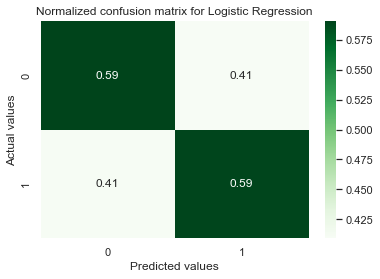

In [5]:
model = LogisticRegression(class_weight="balanced", max_iter=10000)
model.fit(X_train, y_train)
pred = model.predict(X_test)
normalized_cm(y_test, pred, 'Logistic Regression')

**RANDOM FOREST.**

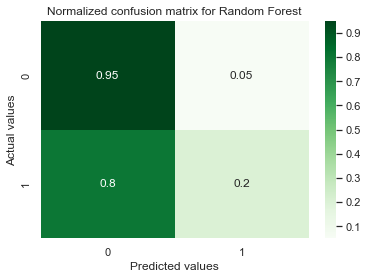

In [6]:
model = RandomForestClassifier(class_weight="balanced", max_depth=20)
model.fit(X_train, y_train)
pred = model.predict(X_test)
normalized_cm(y_test, pred, 'Random Forest')

In [7]:
counter = Counter(y)
estimate = counter[0] / counter[1]
print("Estimate: %.3f" % estimate)

Estimate: 11.387


**XGBClassifier.**

,precision,recall,f1-score,support
0,0.958744,0.713004,0.817812,84806.000000
1,0.166044,0.650644,0.264570,7448.000000
accuracy,0.707969,0.707969,0.707969,0.707969
macro avg,0.562394,0.681824,0.541191,92254.000000
weighted avg,0.894746,0.707969,0.773147,92254.000000


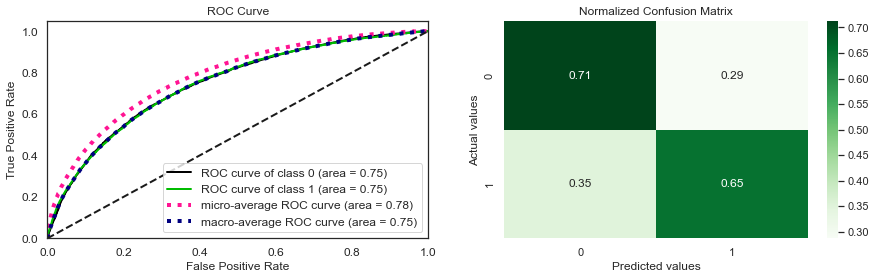

AUC on a test set: 0.746


In [8]:
clf = xgboost_class.XGBoostClassifier(n_estimators=30, objective='binary:logistic', scale_pos_weight = 11.4, random_state=0)
clf.fit(X_train, y_train)
clf.evaluate(X_test, y_test)

Hyperparameter tuning.

Best parameters: {'subsample': 0.8, 'reg_lambda': 0.001, 'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Best AUC: 0.7473


,precision,recall,f1-score,support
0,0.959018,0.723498,0.824774,84806.000000
1,0.170681,0.647959,0.270190,7448.000000
accuracy,0.717400,0.717400,0.717400,0.717400
macro avg,0.564849,0.685729,0.547482,92254.000000
weighted avg,0.895372,0.717400,0.780000,92254.000000


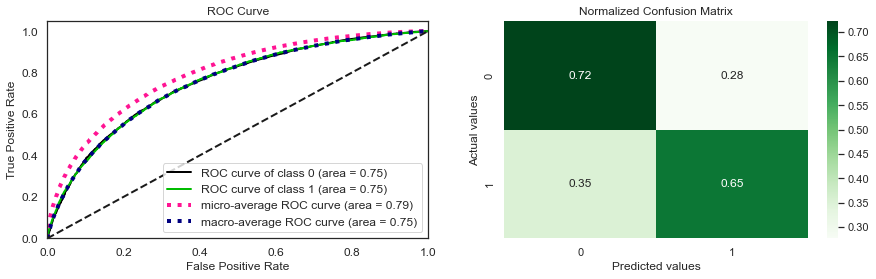

AUC on a test set: 0.751


In [9]:
param_distributions = {
    'max_depth': [3, 5, 6, 7, 8, 10, 15, 20],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [30, 50, 100, 120, 200, 500],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1, 10, 100],
    'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 10, 100]
}

clf = xgboost_class.XGBoostClassifier(objective='binary:logistic', scale_pos_weight = 11.4, random_state=0)
clf.random_search(X_train, y_train, param_distributions, n_iter=15, cv=3, n_jobs=-1)
clf.evaluate(X_test, y_test)

**Feature Importance visualisation.**

,precision,recall,f1-score,support
0,0.961048,0.700847,0.810577,84806.000000
1,0.165708,0.676557,0.266212,7448.000000
accuracy,0.698886,0.698886,0.698886,0.698886
macro avg,0.563378,0.688702,0.538395,92254.000000
weighted avg,0.896837,0.698886,0.766629,92254.000000


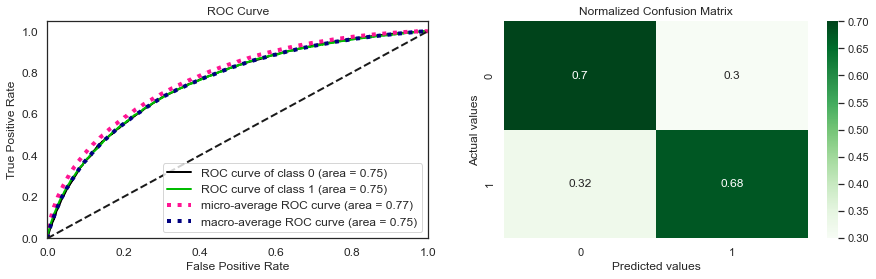

AUC on a test set: 0.752


In [10]:
clf = xgboost_class.XGBoostClassifier(
    objective="binary:logistic",
    scale_pos_weight=11.4,
    random_state=0,
    **{
        "subsample": 0.9,
        "reg_lambda": 10,
        "reg_alpha": 0.001,
        "n_estimators": 50,
        "max_depth": 5,
        "learning_rate": 0.2,
        "colsample_bytree": 1.0,
    }
)
clf.fit(X_train, y_train)
clf.evaluate(X_test, y_test)

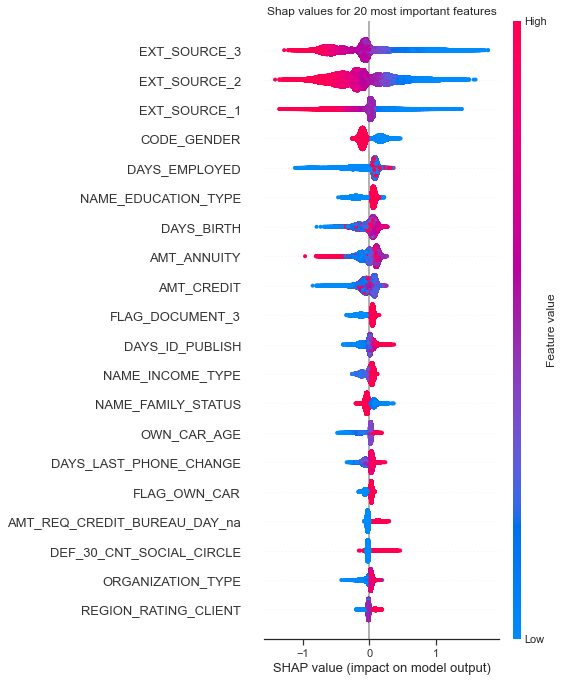

In [11]:
feature_names = preprocessor.get_feature_names_out()
clf.explain(X_train, feature_names)

----
### Adding external features from `bureau` and `bureau_balance` datasets

In [12]:
features_bureau = pd.read_csv('features_bureau.csv').drop(labels=["Unnamed: 0"], axis=1)
features_bureau.head()

,SK_ID_CURR,NUMBER_OF_PREVIOUS_CREDITS,AMT_CREDIT_TOTAL_SUM,TOTAL_COUNT_DAYS_OVERDUE,TOTAL_CREDITS_PROLONGED,AMT_CREDIT_SUM_OVERDUE,TRUST_INDICATOR,FLAG_1_OVERDUE
0,120860,116,9227762.055,0,0,0.0,3.99,0
1,169704,94,8288793.810,0,1,0.0,NaN,1
2,318065,78,7622383.905,0,0,0.0,0.00,0
3,251643,61,2906545.860,0,0,45.0,0.00,1
4,425396,60,1746000.000,0,0,0.0,-0.01,0


In [13]:
appl_bureau = data.merge(features_bureau, how='left', on='SK_ID_CURR')
appl_bureau.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NUMBER_OF_PREVIOUS_CREDITS,AMT_CREDIT_TOTAL_SUM,TOTAL_COUNT_DAYS_OVERDUE,TOTAL_CREDITS_PROLONGED,AMT_CREDIT_SUM_OVERDUE,TRUST_INDICATOR,FLAG_1_OVERDUE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,1.0,8.0,865055.565,0.0,0.0,0.0,3.97,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,4.0,1017400.500,0.0,0.0,0.0,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,2.0,189037.800,0.0,0.0,0.0,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,1.0,146250.000,0.0,0.0,0.0,NaN,0.0


In [14]:
X = appl_bureau.drop(labels=['SK_ID_CURR','TARGET'], axis=1)
y = appl_bureau['TARGET']

preprocessor = DataPreprocessor(X, y)
preprocessor.preprocess_data()

X_train = preprocessor.X_train
X_test = preprocessor.X_test
y_train = preprocessor.y_train
y_test = preprocessor.y_test

preprocessor.fit(X_train)

X_train, X_test = preprocessor.transform(preprocessor.X_train, preprocessor.X_test)


,precision,recall,f1-score,support
0,0.958489,0.712249,0.817223,84806.000000
1,0.165281,0.648765,0.263446,7448.000000
accuracy,0.707124,0.707124,0.707124,0.707124
macro avg,0.561885,0.680507,0.540335,92254.000000
weighted avg,0.894450,0.707124,0.772515,92254.000000


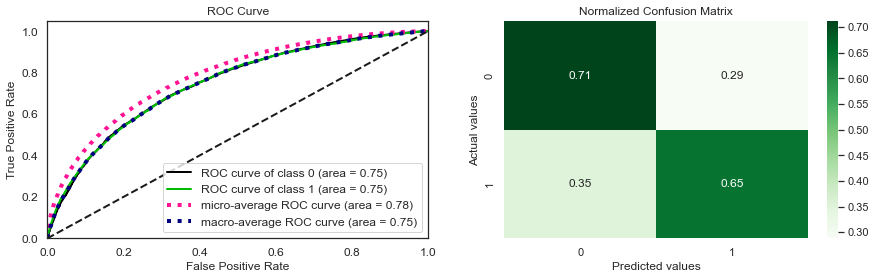

AUC on a test set: 0.745


In [15]:
clf = xgboost_class.XGBoostClassifier(n_estimators=30, objective='binary:logistic', scale_pos_weight = 11.4, random_state=0)
clf.fit(X_train, y_train)
clf.evaluate(X_test, y_test)

Best parameters: {'subsample': 0.8, 'reg_lambda': 0.001, 'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Best AUC: 0.7480


,precision,recall,f1-score,support
0,0.959239,0.723156,0.824634,84806.000000
1,0.170975,0.650107,0.270745,7448.000000
accuracy,0.717259,0.717259,0.717259,0.717259
macro avg,0.565107,0.686632,0.547689,92254.000000
weighted avg,0.895600,0.717259,0.779916,92254.000000


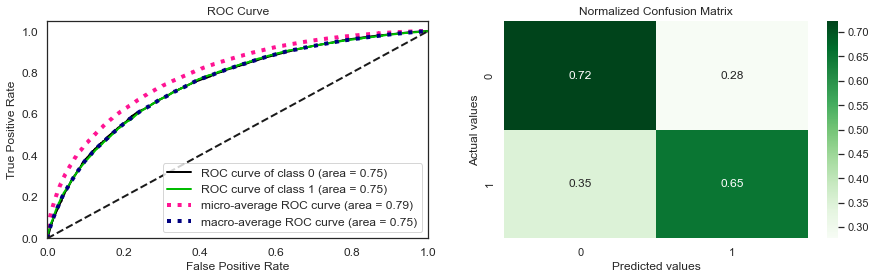

AUC on a test set: 0.752


In [16]:
param_distributions = {
    'max_depth': [3, 5, 6, 7, 8, 10, 15, 20],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [30, 50, 100, 120, 200, 500],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1, 10, 100],
    'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 10, 100]
}

clf = xgboost_class.XGBoostClassifier(objective='binary:logistic', scale_pos_weight = 11.4, random_state=0)
clf.random_search(X_train, y_train, param_distributions, n_iter=15, cv=3, n_jobs=-1)
clf.evaluate(X_test, y_test)

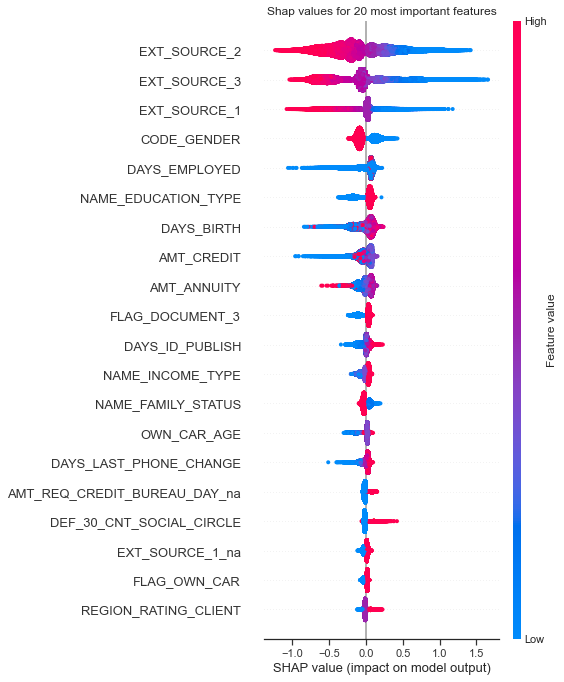

In [17]:
clf = xgboost_class.XGBoostClassifier(
    objective="binary:logistic",
    scale_pos_weight=11.4,
    random_state=0,
    **{
        "subsample": 0.8,
        "reg_lambda": 0.001,
        "reg_alpha": 0.1,
        "n_estimators": 500,
        "max_depth": 7,
        "learning_rate": 0.01,
        "colsample_bytree": 0.9,
    }
)
clf.fit(X_train, y_train)
feature_names = preprocessor.get_feature_names_out()
clf.explain(X_train, feature_names)

CONCLUSION: any of the additional features from `BUREAU` improved modeling of payment difficulties.

----
### Adding external features from `previous_application` dataset

In [5]:
features_prev_appl = pd.read_csv('prev_appl_install.csv')

In [6]:
appl_prev_appl = data.merge(features_prev_appl, how='left', on='SK_ID_CURR')
appl_prev_appl.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV,TOTAL_AMT_OF_PREV_CREDITS,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,TOTAL_PAYMENT_AGREEMENT,TOTAL_PAYMENT_ACTUAL,NUM_INSTALMENT_NUMBER,PAYMENT_RATIO
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,1.0,1.0,179055.0,-565.0,125.0,-25.0,219625.695,219625.695,19.0,1.000000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,3.0,1452573.0,-2310.0,-1980.0,-1980.0,1618864.650,1618864.650,25.0,1.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,1.0,20106.0,-784.0,-694.0,-724.0,21288.465,21288.465,3.0,1.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,8.0,1718644.5,-545.0,-215.0,-425.0,1007153.415,1007153.415,16.0,1.000000
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,6.0,999832.5,-2326.0,-2056.0,-2056.0,835985.340,806127.975,66.0,0.964285


In [20]:
X = appl_prev_appl.drop(labels=['SK_ID_CURR','TARGET'], axis=1)
y = appl_prev_appl['TARGET']

preprocessor = DataPreprocessor(X, y)
preprocessor.preprocess_data()

X_train = preprocessor.X_train
X_test = preprocessor.X_test
y_train = preprocessor.y_train
y_test = preprocessor.y_test

preprocessor.fit(X_train)

X_train, X_test = preprocessor.transform(preprocessor.X_train, preprocessor.X_test)


,precision,recall,f1-score,support
0,0.959970,0.716282,0.820413,84806.000000
1,0.169623,0.659909,0.269877,7448.000000
accuracy,0.711731,0.711731,0.711731,0.711731
macro avg,0.564797,0.688095,0.545145,92254.000000
weighted avg,0.896163,0.711731,0.775966,92254.000000


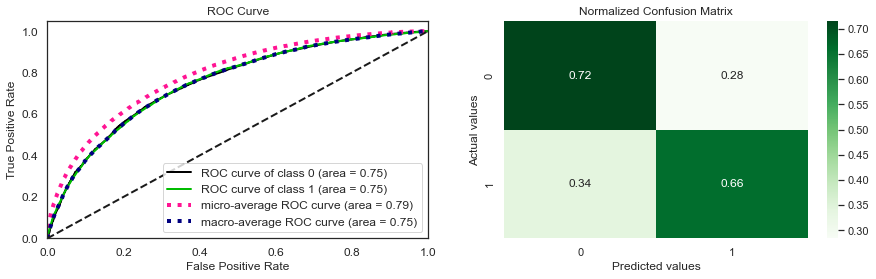

AUC on a test set: 0.752


In [21]:
clf = xgboost_class.XGBoostClassifier(n_estimators=30, objective='binary:logistic', scale_pos_weight = 11.4, random_state=0)
clf.fit(X_train, y_train)
clf.evaluate(X_test, y_test)

Best parameters: {'subsample': 0.9, 'reg_lambda': 10, 'reg_alpha': 0.001, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Best AUC: 0.7538


,precision,recall,f1-score,support
0,0.961474,0.709796,0.816685,84806.000000
1,0.169865,0.676155,0.271519,7448.000000
accuracy,0.707080,0.707080,0.707080,0.707080
macro avg,0.565670,0.692976,0.544102,92254.000000
weighted avg,0.897565,0.707080,0.772672,92254.000000


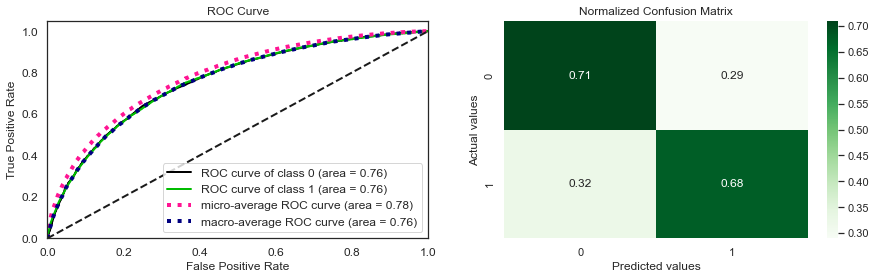

AUC on a test set: 0.758


In [23]:
param_distributions = {
    'max_depth': [3, 5, 6, 7, 8, 10, 15, 20],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [30, 50, 100, 120, 200, 500],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1, 10, 100],
    'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 10, 100]
}

clf = xgboost_class.XGBoostClassifier(objective='binary:logistic', scale_pos_weight = 11.4, random_state=0)
clf.random_search(X_train, y_train, param_distributions, n_iter=15, cv=3, n_jobs=-1)
clf.evaluate(X_test, y_test)

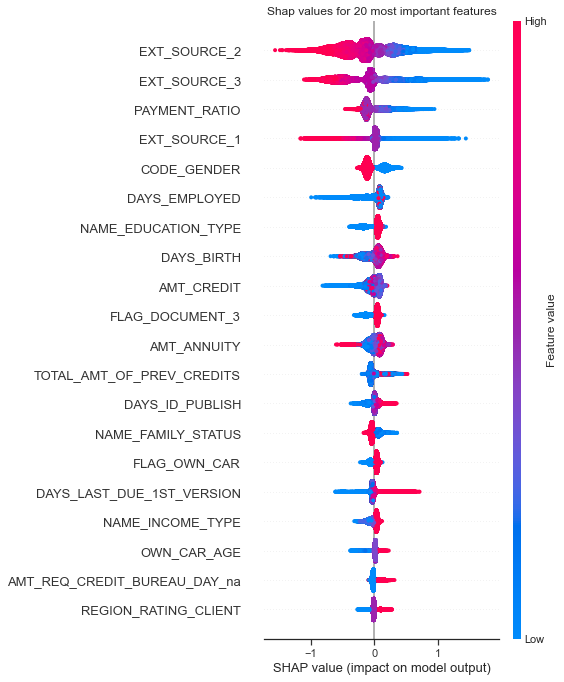

In [24]:
clf = xgboost_class.XGBoostClassifier(
    objective="binary:logistic",
    scale_pos_weight=11.4,
    random_state=0,
    **{
        "subsample": 0.9,
        "reg_lambda": 10,
        "reg_alpha": 0.001,
        "n_estimators": 50,
        "max_depth": 5,
        "learning_rate": 0.2,
        "colsample_bytree": 1.0,
    }
)

clf.fit(X_train, y_train)
feature_names = preprocessor.get_feature_names_out()
clf.explain(X_train, feature_names)

----
### Adding external features from `credit_card_balance` dataset


In [7]:
cc_grouped = pd.read_csv('cc_grouped.csv')
cc_grouped.head()

,SK_ID_CURR,TOTAL_NUMBER_CREDIT_CARDS,SK_DPD,SK_DPD_DEF,DPD_IMPORTANT
0,186401,192,0.114583,0.114583,1.0
1,311118,178,0.000000,0.000000,NaN
2,120076,140,0.000000,0.000000,NaN
3,128827,129,0.139535,0.139535,1.0
4,432607,128,0.000000,0.000000,NaN


In [8]:
cc_prev = appl_prev_appl.merge(cc_grouped, how='left', on='SK_ID_CURR')
cc_prev.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,TOTAL_PAYMENT_AGREEMENT,TOTAL_PAYMENT_ACTUAL,NUM_INSTALMENT_NUMBER,PAYMENT_RATIO,TOTAL_NUMBER_CREDIT_CARDS,SK_DPD,SK_DPD_DEF,DPD_IMPORTANT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,125.0,-25.0,219625.695,219625.695,19.0,1.000000,NaN,NaN,NaN,NaN
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,-1980.0,-1980.0,1618864.650,1618864.650,25.0,1.000000,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,-694.0,-724.0,21288.465,21288.465,3.0,1.000000,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,-215.0,-425.0,1007153.415,1007153.415,16.0,1.000000,6.0,0.0,0.0,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,-2056.0,-2056.0,835985.340,806127.975,66.0,0.964285,NaN,NaN,NaN,NaN


In [27]:
X = cc_prev.drop(labels=['SK_ID_CURR','TARGET'], axis=1)
y = cc_prev['TARGET']

preprocessor = DataPreprocessor(X, y)
preprocessor.preprocess_data()

X_train = preprocessor.X_train
X_test = preprocessor.X_test
y_train = preprocessor.y_train
y_test = preprocessor.y_test

preprocessor.fit(X_train)

X_train, X_test = preprocessor.transform(preprocessor.X_train, preprocessor.X_test)

,precision,recall,f1-score,support
0,0.959693,0.718723,0.821910,84806.000000
1,0.170065,0.656284,0.270130,7448.000000
accuracy,0.713682,0.713682,0.713682,0.713682
macro avg,0.564879,0.687503,0.546020,92254.000000
weighted avg,0.895943,0.713682,0.777362,92254.000000


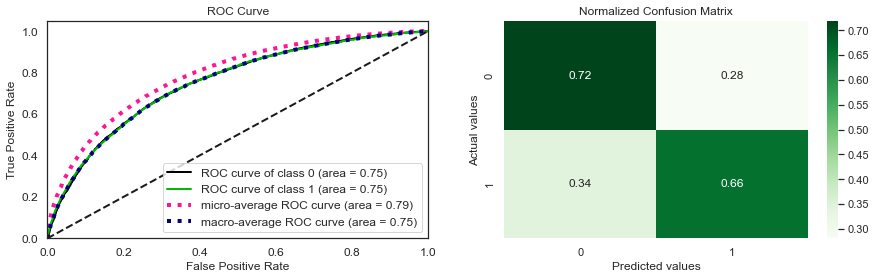

AUC on a test set: 0.752


In [28]:
clf = xgboost_class.XGBoostClassifier(n_estimators=30, objective='binary:logistic', scale_pos_weight = 11.4, random_state=0)
clf.fit(X_train, y_train)
clf.evaluate(X_test, y_test)

Best parameters: {'subsample': 0.8, 'reg_lambda': 0.001, 'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Best AUC: 0.7538


,precision,recall,f1-score,support
0,0.960103,0.730691,0.829834,84806.000000
1,0.175844,0.654270,0.277190,7448.000000
accuracy,0.724521,0.724521,0.724521,0.724521
macro avg,0.567974,0.692480,0.553512,92254.000000
weighted avg,0.896787,0.724521,0.785217,92254.000000


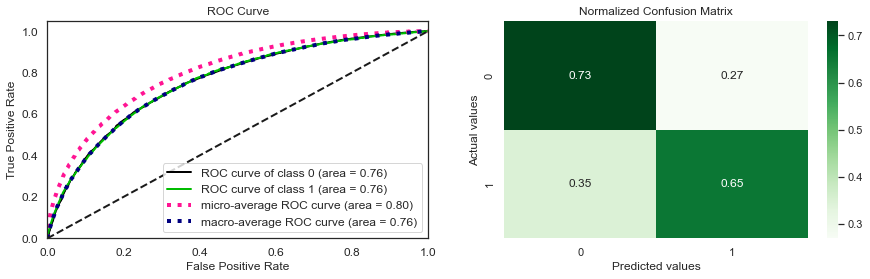

AUC on a test set: 0.758


In [29]:
param_distributions = {
    'max_depth': [3, 5, 6, 7, 8, 10, 15, 20],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [30, 50, 100, 120, 200, 500],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1, 10, 100],
    'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 10, 100]
}

clf = xgboost_class.XGBoostClassifier(objective='binary:logistic', scale_pos_weight = 11.4, random_state=0)
clf.random_search(X_train, y_train, param_distributions, n_iter=15, cv=3, n_jobs=-1)
clf.evaluate(X_test, y_test)

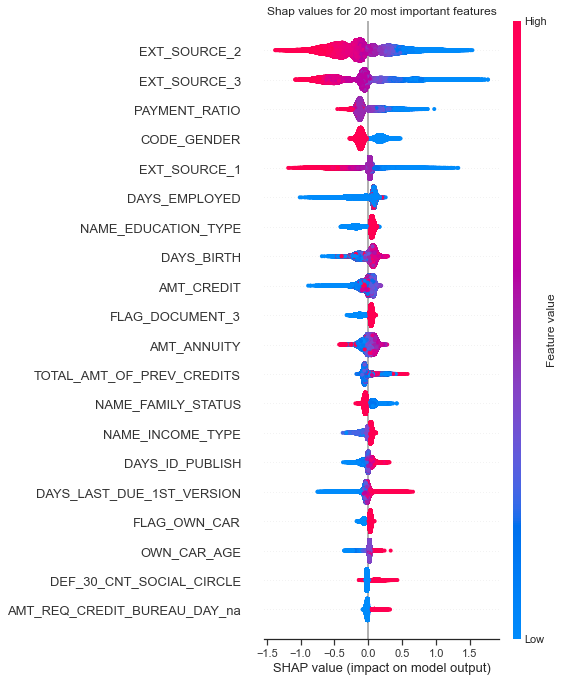

In [30]:
clf = xgboost_class.XGBoostClassifier(
    objective="binary:logistic",
    scale_pos_weight=11.4,
    random_state=0,
    **{
        "subsample": 0.9,
        "reg_lambda": 10,
        "reg_alpha": 0.001,
        "n_estimators": 50,
        "max_depth": 5,
        "learning_rate": 0.2,
        "colsample_bytree": 1.0,
    }
)

clf.fit(X_train, y_train)
feature_names = preprocessor.get_feature_names_out()
clf.explain(X_train, feature_names)

----
### Adding external features from `pos_cash_balance` dataset

In [9]:
pos_cash_limited = pd.read_csv('pos_cash_limited.csv')
pos_cash_limited.head()

,SK_ID_CURR,TOTAL_NB_POS_CASH,SK_DPD_PC,SK_DPD_DEF_PC,DPD_IMPORTANT_PC
0,265042,295,0.000000,0.000000,NaN
1,172612,247,0.044534,0.044534,1.0
2,309133,246,0.000000,0.000000,NaN
3,127659,245,0.000000,0.000000,NaN
4,197583,245,0.000000,0.000000,NaN


In [10]:
cc_pc_prev = cc_prev.merge(pos_cash_limited, how='left', on='SK_ID_CURR')
cc_pc_prev.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,NUM_INSTALMENT_NUMBER,PAYMENT_RATIO,TOTAL_NUMBER_CREDIT_CARDS,SK_DPD,SK_DPD_DEF,DPD_IMPORTANT,TOTAL_NB_POS_CASH,SK_DPD_PC,SK_DPD_DEF_PC,DPD_IMPORTANT_PC
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,19.0,1.000000,NaN,NaN,NaN,NaN,19.0,0.0,0.0,NaN
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,25.0,1.000000,NaN,NaN,NaN,NaN,28.0,0.0,0.0,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,3.0,1.000000,NaN,NaN,NaN,NaN,4.0,0.0,0.0,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,16.0,1.000000,6.0,0.0,0.0,NaN,21.0,0.0,0.0,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,66.0,0.964285,NaN,NaN,NaN,NaN,66.0,0.0,0.0,NaN


In [33]:
X = cc_pc_prev.drop(labels=['SK_ID_CURR','TARGET'], axis=1)
y = cc_pc_prev['TARGET']

preprocessor = DataPreprocessor(X, y)
preprocessor.preprocess_data()

X_train = preprocessor.X_train
X_test = preprocessor.X_test
y_train = preprocessor.y_train
y_test = preprocessor.y_test

preprocessor.fit(X_train)

X_train, X_test = preprocessor.transform(preprocessor.X_train, preprocessor.X_test)

,precision,recall,f1-score,support
0,0.959313,0.719525,0.822294,84806.000000
1,0.169657,0.652524,0.269297,7448.000000
accuracy,0.714115,0.714115,0.714115,0.714115
macro avg,0.564485,0.686024,0.545796,92254.000000
weighted avg,0.895561,0.714115,0.777649,92254.000000


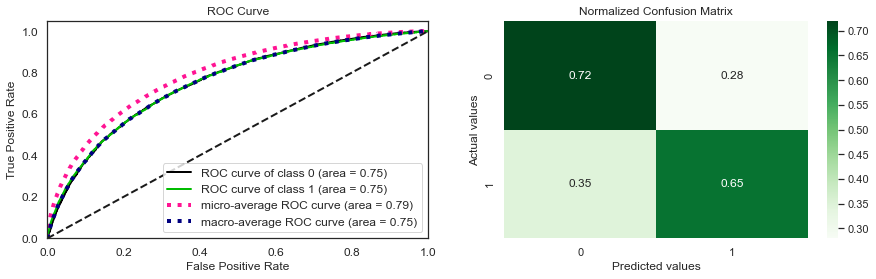

AUC on a test set: 0.752


In [34]:
clf = xgboost_class.XGBoostClassifier(n_estimators=30, objective='binary:logistic', scale_pos_weight = 11.4, random_state=0)
clf.fit(X_train, y_train)
clf.evaluate(X_test, y_test)

Best parameters: {'subsample': 0.8, 'reg_lambda': 0.001, 'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Best AUC: 0.7549


,precision,recall,f1-score,support
0,0.959871,0.732212,0.830727,84806.000000
1,0.176039,0.651450,0.277178,7448.000000
accuracy,0.725692,0.725692,0.725692,0.725692
macro avg,0.567955,0.691831,0.553952,92254.000000
weighted avg,0.896590,0.725692,0.786037,92254.000000


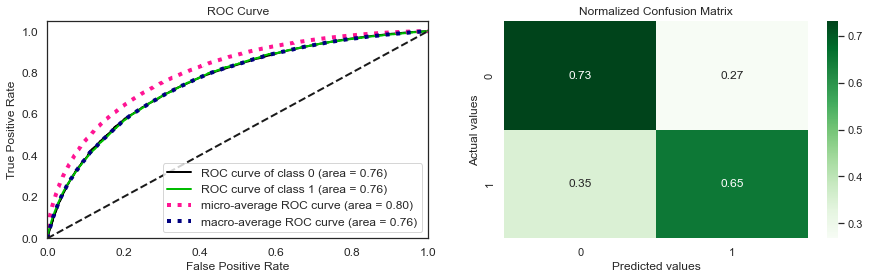

AUC on a test set: 0.759


In [35]:
param_distributions = {
    'max_depth': [3, 5, 6, 7, 8, 10, 15, 20],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [30, 50, 100, 120, 200, 500],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1, 10, 100],
    'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 10, 100]
}

clf = xgboost_class.XGBoostClassifier(objective='binary:logistic', scale_pos_weight = 11.4, random_state=0)
clf.random_search(X_train, y_train, param_distributions, n_iter=15, cv=3, n_jobs=-1)
clf.evaluate(X_test, y_test)

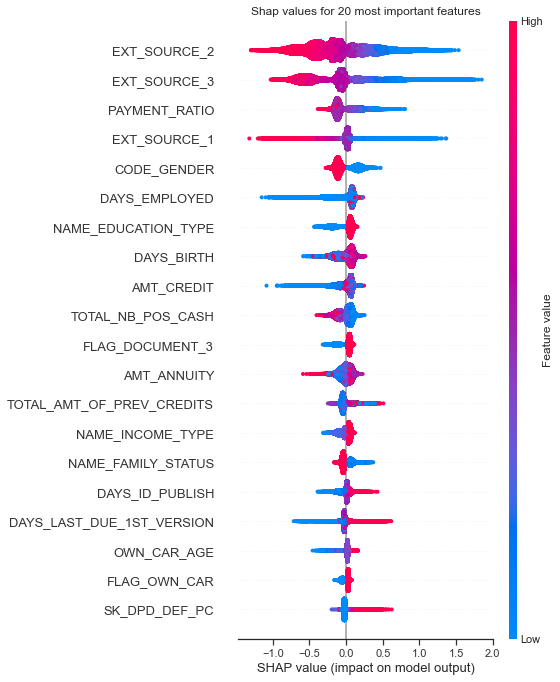

In [36]:
clf = xgboost_class.XGBoostClassifier(
    objective="binary:logistic",
    scale_pos_weight=11.4,
    random_state=0,
    **{
        "subsample": 0.9,
        "reg_lambda": 10,
        "reg_alpha": 0.001,
        "n_estimators": 50,
        "max_depth": 5,
        "learning_rate": 0.2,
        "colsample_bytree": 1.0,
    }
)

clf.fit(X_train, y_train)
feature_names = preprocessor.get_feature_names_out()
clf.explain(X_train, feature_names)

### Boruta Feature Selection

In [37]:
model_boruta = RandomForestClassifier(
    n_estimators=100, max_depth=5, random_state=42, class_weight="balanced"
)

feat_selector = BorutaPy(
    verbose=1, estimator=model_boruta, n_estimators="auto", max_iter=10
)

feat_selector.fit(X_train, np.array(y_train))


Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running.

Iteration: 	10 / 10
Confirmed: 	53
Tentative: 	8
Rejected: 	16


BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=233,
                                          random_state=RandomState(MT19937) at 0x262772D9D40),
         max_iter=10, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x262772D9D40, verbose=1)

In [38]:
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(X_train, columns=feature_names)

In [39]:
accept=X_train_df.columns[feat_selector.support_].to_list()
irresolution = X_train_df.columns[feat_selector.support_weak_].to_list()

print("Accepted features:")
print("----------------------------")
print(list(accept))
print("\nTentative features:")
print("----------------------------")
print(list(irresolution))


Accepted features:
----------------------------
['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'REGION_RATING_CLIENT', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'NONLIVINGAREA_MODE', 'FLOORSMAX_MEDI', 'TOTALAREA_MODE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'SK_ID_PREV', 'TOTAL_AMT_OF_PREV_CREDITS', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'NUM_INSTALMENT_NUMBER', 'PAYMENT_RATIO', 'TOTAL_NUMBER_CREDIT_CARDS', 'TOTAL_NB_POS_CASH', 'SK_DPD_PC', 'SK_DPD_DEF_PC', 'OWN_CAR_AGE_na', 'AMT_REQ_CREDIT_BUREAU_DAY_na', 'DPD_IMPORTANT_PC_na', 'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'FLAG_EMP_PHONE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_M

In [41]:
X_train_b = X_train_df[accept]
X_test_df = pd.DataFrame(X_test, columns=feature_names)
X_test_b = X_test_df[accept]

### Recalculating model on lower number of features

,precision,recall,f1-score,support
0,0.961551,0.712450,0.818466,84806.000000
1,0.171052,0.675618,0.272989,7448.000000
accuracy,0.709476,0.709476,0.709476,0.709476
macro avg,0.566301,0.694034,0.545727,92254.000000
weighted avg,0.897731,0.709476,0.774428,92254.000000


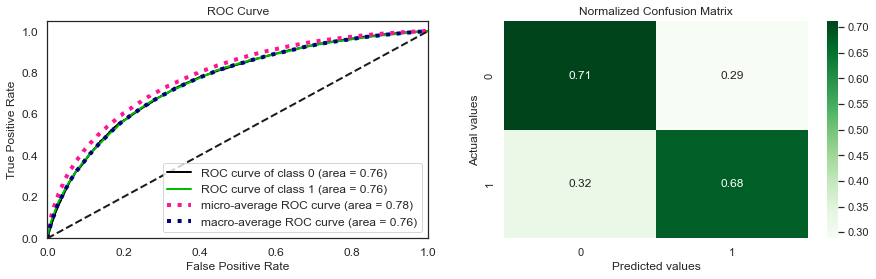

AUC on a test set: 0.758


In [42]:
clf = xgboost_class.XGBoostClassifier(
    objective="binary:logistic",
    scale_pos_weight=11.4,
    random_state=0,
    **{
        "subsample": 0.9,
        "reg_lambda": 10,
        "reg_alpha": 0.001,
        "n_estimators": 50,
        "max_depth": 5,
        "learning_rate": 0.2,
        "colsample_bytree": 1.0,
    }
)

clf.fit(X_train_b, y_train)
clf.evaluate(X_test_b, y_test)

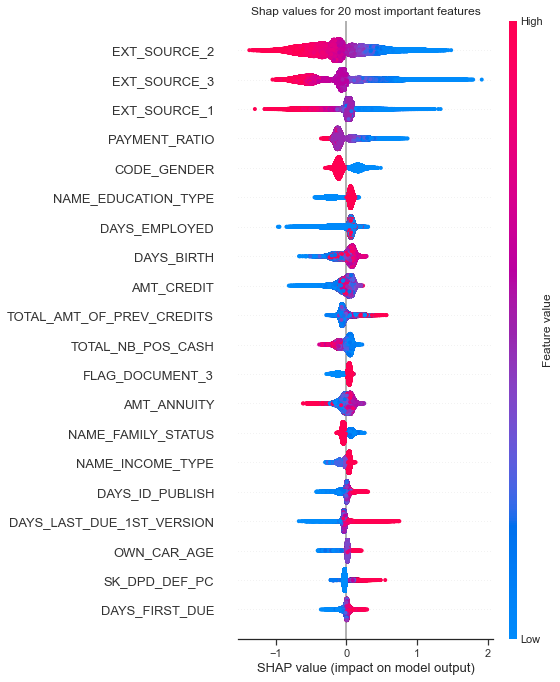

In [43]:
feature_names = X_train_b.columns
clf.explain(X_train_b, feature_names)

### Choosing 15 most important features

In [11]:
X = cc_pc_prev[
    [
        "AMT_CREDIT",
        "CODE_GENDER",
        "DAYS_EMPLOYED",
        "NAME_EDUCATION_TYPE",
        "DAYS_BIRTH",
        "NAME_FAMILY_STATUS",
        "NAME_INCOME_TYPE",
        "FLAG_OWN_CAR",
        "OWN_CAR_AGE",
        "EXT_SOURCE_1",
        "EXT_SOURCE_2",
        "EXT_SOURCE_3",
        'PAYMENT_RATIO',
        'TOTAL_NB_POS_CASH',
        'TOTAL_PAYMENT_AGREEMENT'
    ]
]
y = cc_pc_prev["TARGET"]

preprocessor = DataPreprocessor(X, y)
preprocessor.preprocess_data()

X_train = preprocessor.X_train
X_test = preprocessor.X_test
y_train = preprocessor.y_train
y_test = preprocessor.y_test


In [12]:
preprocessor.fit(X_train)

X_train, X_test = preprocessor.transform(preprocessor.X_train, preprocessor.X_test)

,precision,recall,f1-score,support
0,0.960320,0.701165,0.810531,84806.000000
1,0.164535,0.670113,0.264200,7448.000000
accuracy,0.698658,0.698658,0.698658,0.698658
macro avg,0.562427,0.685639,0.537366,92254.000000
weighted avg,0.896073,0.698658,0.766424,92254.000000


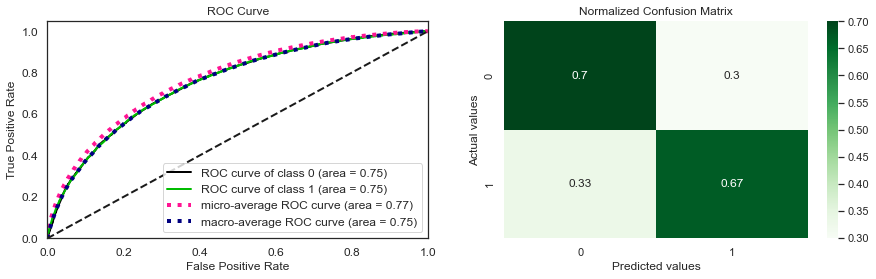

AUC on a test set: 0.752


In [46]:
clf = xgboost_class.XGBoostClassifier(
    objective="binary:logistic",
    scale_pos_weight=11.4,
    random_state=0,
    **{
        "subsample": 0.9,
        "reg_lambda": 10,
        "reg_alpha": 0.001,
        "n_estimators": 50,
        "max_depth": 5,
        "learning_rate": 0.2,
        "colsample_bytree": 1.0,
    }
)

clf.fit(X_train, y_train)
clf.evaluate(X_test, y_test)

Best parameters: {'subsample': 0.8, 'reg_lambda': 0.001, 'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Best AUC: 0.7488


,precision,recall,f1-score,support
0,0.959789,0.717992,0.821467,84806.000000
1,0.169958,0.657492,0.270097,7448.000000
accuracy,0.713107,0.713107,0.713107,0.713107
macro avg,0.564874,0.687742,0.545782,92254.000000
weighted avg,0.896023,0.713107,0.776953,92254.000000


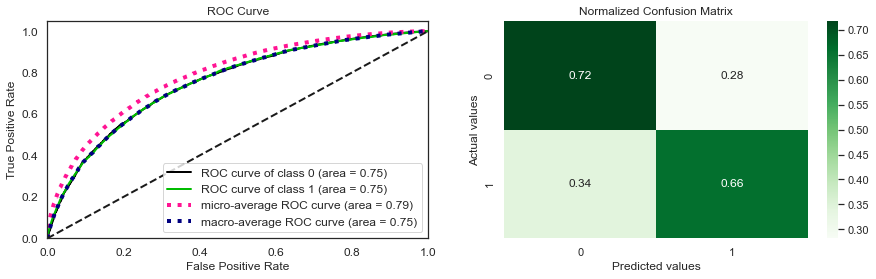

AUC on a test set: 0.753


In [52]:
param_distributions = {
    'max_depth': [3, 5, 6, 7, 8, 10, 15, 20],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [30, 50, 100, 120, 200, 500],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1, 10, 100],
    'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 10, 100]
}

clf = xgboost_class.XGBoostClassifier(objective='binary:logistic', scale_pos_weight = 11.4, random_state=0)
clf.random_search(X_train, y_train, param_distributions, n_iter=15, cv=3, n_jobs=-1)
clf.evaluate(X_test, y_test)

In [13]:
clf = xgboost_class.XGBoostClassifier(
    objective="binary:logistic",
    scale_pos_weight=11.4,
    random_state=0,
    **{
        "subsample": 0.8,
        "reg_lambda": 0.001,
        "reg_alpha": 0.1,
        "n_estimators": 500,
        "max_depth": 7,
        "learning_rate": 0.01,
        "colsample_bytree": 0.9,
    }
)

clf.fit(X_train, y_train)

In [51]:
data_for_cost_calculation = cc_pc_prev[
    [   
        "TARGET",
        "AMT_CREDIT",
        "AMT_ANNUITY",
        "CODE_GENDER",
        "DAYS_EMPLOYED",
        "NAME_EDUCATION_TYPE",
        "DAYS_BIRTH",
        "NAME_FAMILY_STATUS",
        "NAME_INCOME_TYPE",
        "FLAG_OWN_CAR",
        "OWN_CAR_AGE",
        "EXT_SOURCE_1",
        "EXT_SOURCE_2",
        "EXT_SOURCE_3",
        'PAYMENT_RATIO',
        'TOTAL_NB_POS_CASH',
        'TOTAL_PAYMENT_AGREEMENT'
    ]
]

data_for_cost_calculation.to_csv("data_for_cost_calculation.csv")

----
----